In [1]:
%matplotlib inline


# Iterated Masked sifting
Masking signals are a powerful method for reducing the mode mixing problem when
running EMD on noisy or transient signals. However, the standard methods for
selecting masks often perform poorly in real data and selecting masks by hand
can be cumbersome and prone to error.

This tutorial introduces iterated masking EMD (itEMD), a recent sifting method
that automates mask signal frequencies based on the dynamics present in the
data. We will show how it automatically dentifies oscillations and minimises
mode mixing without prespecification of masking signals.

The method is published in the following paper:

Marco S. Fabus, Andrew J. Quinn, Catherine E. Warnaby, and Mark W. Woolrich (2021).
Automatic decomposition of electroptysiological data into distinct nonsinusoidal oscillatory modes.
Journal of Neurophysiology 2021 126:5, 1670-1684.
https://doi.org/10.1152/jn.00315.2021


## Issues with Mask Selection



Let's start by simulating a signal with a 2Hz nonsinusoidal oscillation and 30Hz beta bursts.



(0.0, 3.0)

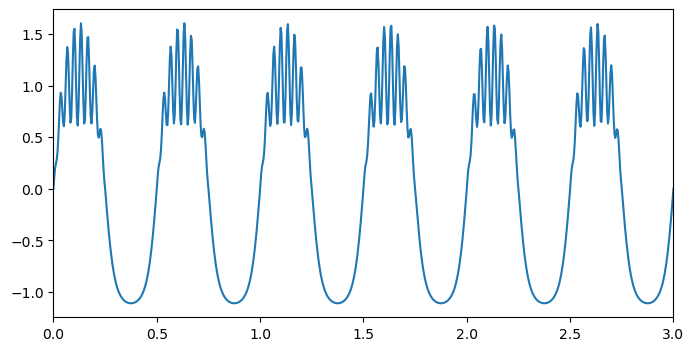

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emd

np.random.seed(0)
sample_rate = 256
seconds = 3
num_samples = sample_rate*seconds

time_vect = np.linspace(0, seconds, num_samples)

# Create an amplitude modulation
freq = 2
am = np.sin(2*np.pi*freq*time_vect)
am[am < 0] = 0

# Non-sinusoidal intermittend 2Hz signal
x1 = np.sin(np.sin(np.sin(np.sin(np.sin(np.sin(np.sin(2*np.pi*freq*time_vect))))))) / 0.5

# Bursting 30Hz oscillation
x2 = am *  0.5 * np.cos(2*np.pi*30*time_vect)

# Sum them together
x = x1 + x2

# Quick summary figure
plt.figure(figsize=(8, 4))
plt.plot(time_vect, x)
plt.xlim(0,  3)

# sphinx_gallery_thumbnail_number = 6

Let's run the default mask sift, where mask frequency is determined from zero crossings of the signal.



<AxesSubplot:xlabel='Time (samples)'>

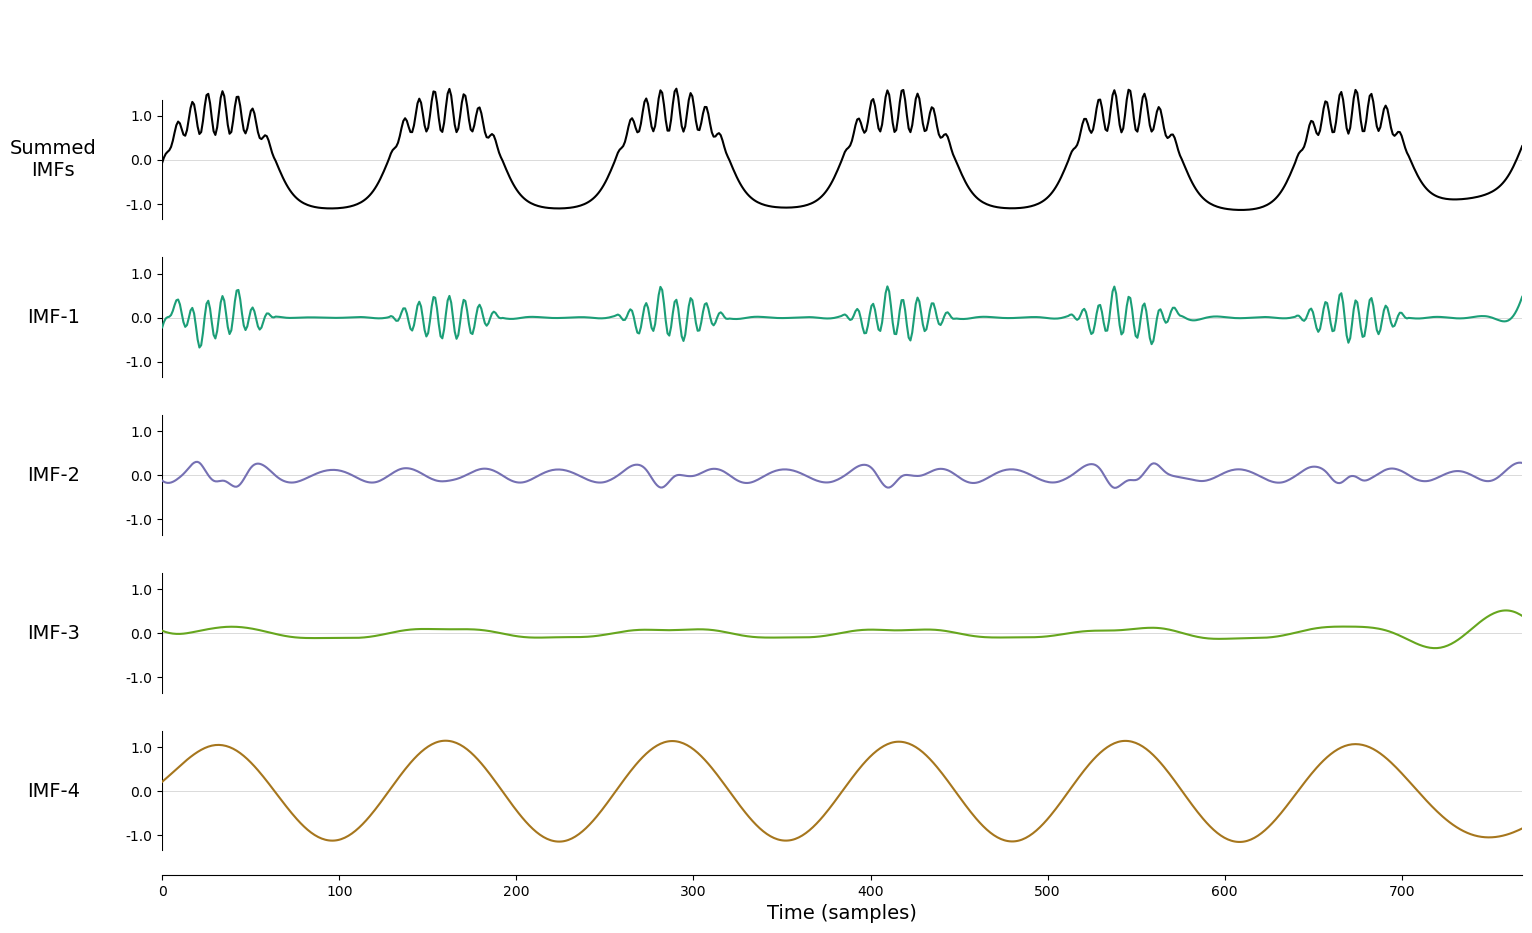

In [3]:
imf = emd.sift.mask_sift(x, max_imfs=4)
emd.plotting.plot_imfs(imf)

We can see that the result is not great. Bursting beta is in IMF-1, but the
non-sinusoidal oscillation is split between IMF-2 and IMF-4. This is because
the waveform is highly non-sinusoidal and spans a lot of frequencies,
confusing the default mask sift. Let's try the same thing, but now with
custom mask frequencies.



<AxesSubplot:xlabel='Time (samples)'>

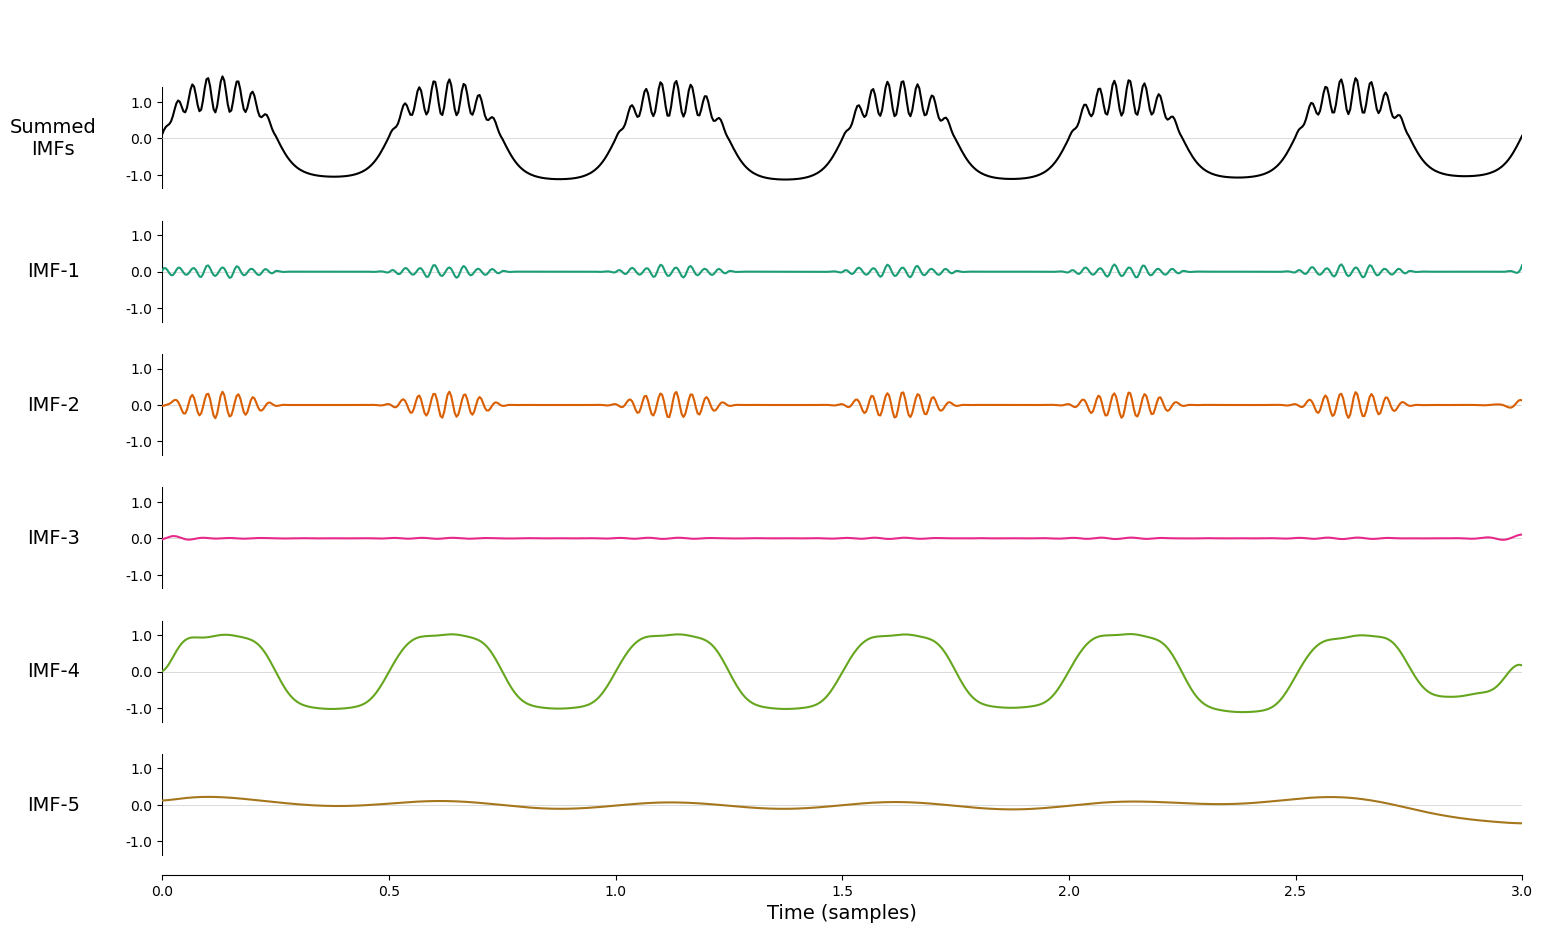

In [4]:
mask = np.array([60, 30, 24, 2, 1, 0.5])/sample_rate
imf = emd.sift.mask_sift(x, max_imfs=5, mask_freqs=mask)
emd.plotting.plot_imfs(imf, time_vect=time_vect)

Better! Most of the 2Hz oscillation is now in IMF-4 and most of bursting beta
in IMF-2. However, it's still not perfect - beta is slightly split between
IMF-1 and IMF-2 and we have an unnecessary 'empty' mode IMF-3. Finding a mask
that balances all of these issues can be an arduous manual process. How could
we do this automatically? Let's come back to our original sift and look at
the mean instantaneous frequencies of the modes weighted by instantaneous
amplitude.



In [5]:
imf = emd.sift.mask_sift(x, max_imfs=4)
IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
print(np.average(IF, 0, weights=IA**2))

[27.04427481  6.20693296  1.63994241  1.9635715 ]


## Automated Mask Selection



Even though the modes are split, frequencies of the first two modes are close
to the ground truths of 30Hz and 2Hz that we know. What happens if we take
these frequencies as the mask for masked sift?



<AxesSubplot:xlabel='Time (samples)'>

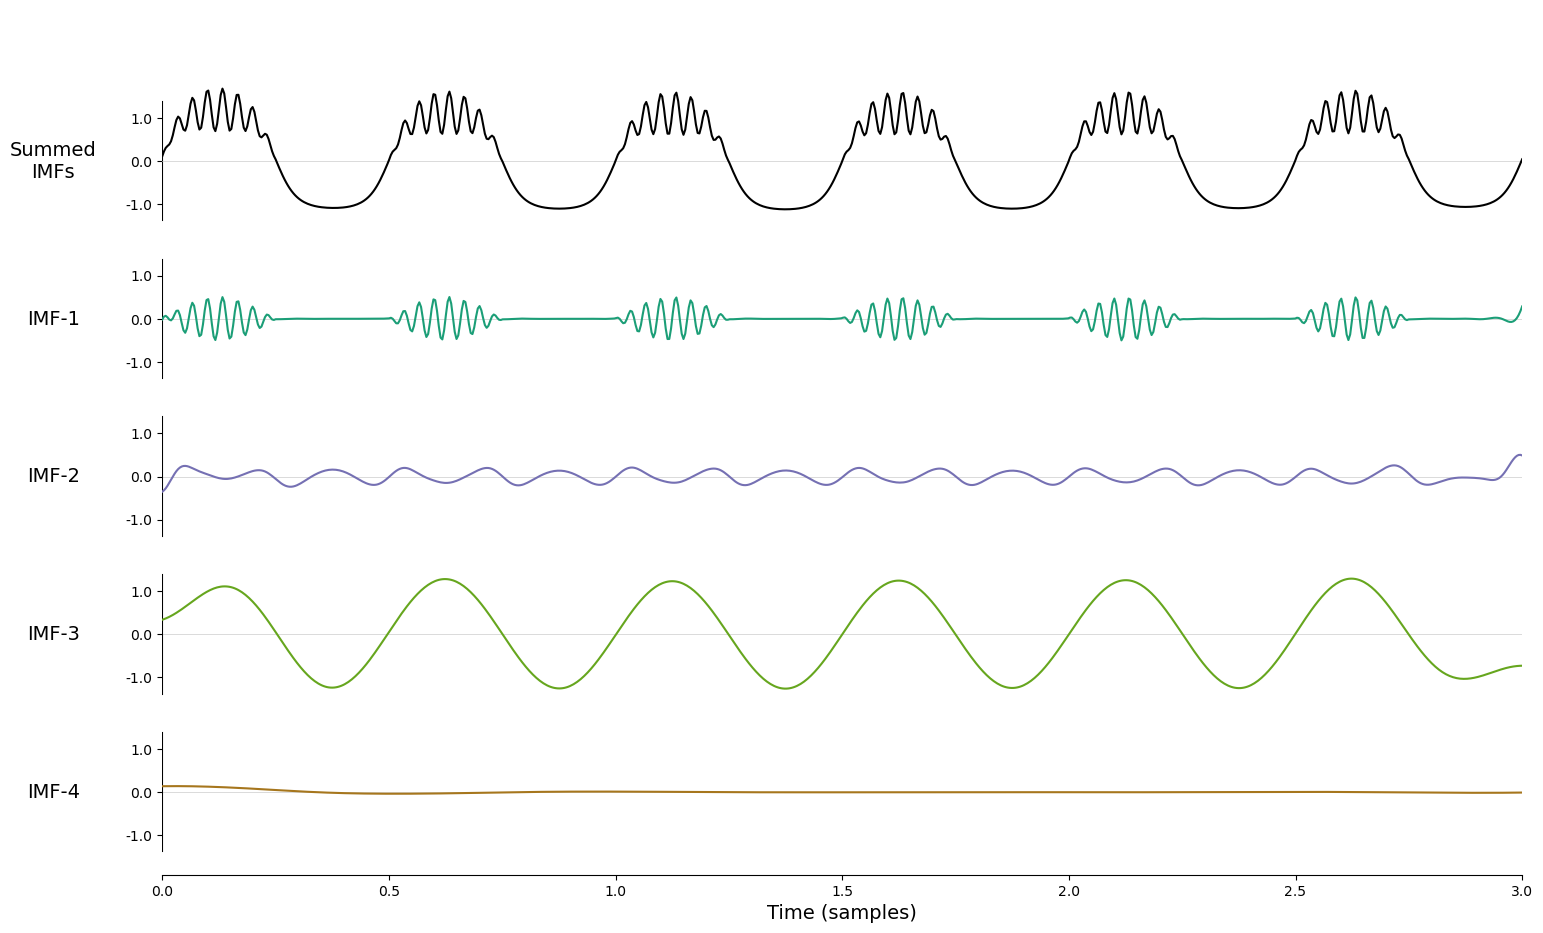

In [6]:
# Compute the default mask sift
imf = emd.sift.mask_sift(x, max_imfs=4)

# Take the mean IF as new mask, compute mask sift again and plot
IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
mask_1 = np.average(IF, 0, weights=IA**2) / sample_rate
imf = emd.sift.mask_sift(x, max_imfs=4, mask_freqs=mask_1)
emd.plotting.plot_imfs(imf, time_vect=time_vect)

We have now removed the empty mode and the
bursting beta in is entirely IMF-1. It's certainly an improvement on the default sift.
Let's repeat this process ten times and track what happens to average
frequencies of the first two IMFs.



In [9]:
# Compute the default mask sift
imf, mask_0 = emd.sift.mask_sift(x, max_imfs=4, ret_mask_freq=True)

# Take the mean IF as new mask, compute mask sift again and plot
IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
mask = np.average(IF, 0, weights=IA**2) / sample_rate

# Save all masks:
mask_all = np.zeros((3, 12))
mask_all[:, 0] = mask_0[:3]
mask_all[:, 1] = mask[:3]

for i in range(10):
    imf = emd.sift.mask_sift(x, max_imfs=4, mask_freqs=mask)
    IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
    mask = np.average(IF, 0, weights=IA**2) / sample_rate
    mask_all[:, i+2] = mask[:3]

plt.figure()
for i in range(2):
    plt.plot(mask_all[i, :]*sample_rate)
plt.xlabel('Iteration #')
plt.ylabel('Mask frequency [Hz]')
plt.show()


Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


LinAlgError: SVD did not converge in Linear Least Squares

The iteration process rapidly converged on the ground truth frequencies, 2Hz
and 30Hz! This is the essence of iterated masking EMD (itEMD). By finding the
equilibrium between masks and IMF frequencies, we automatically extract
oscillations of interest in a data-driven way. Let's apply itEMD directly and
show the result.



<AxesSubplot:xlabel='Time (samples)'>

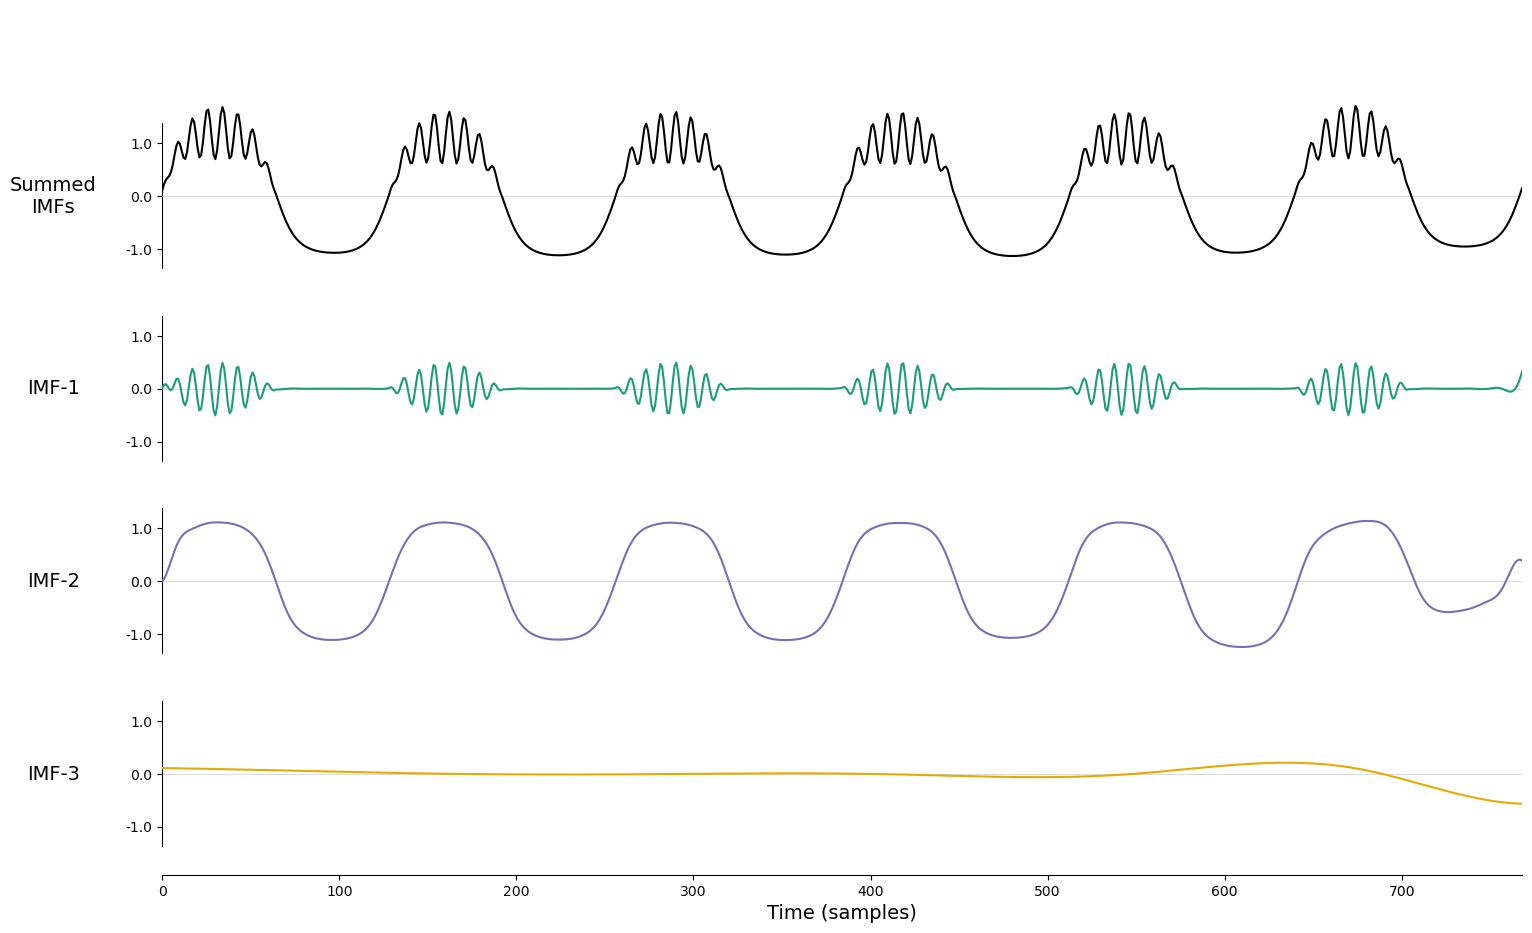

In [10]:
imf = emd.sift.iterated_mask_sift(x, sample_rate=sample_rate, max_imfs=3)
emd.plotting.plot_imfs(imf)

And that's it! We have identified both the bursting beta and a non-sinusoidal
oscillation automatically and without 'empty' modes between them.

This decomposition has a clear Hilbert-Huang transform in the amplitude
modulations of the 30Hz signal and within-cycle instantaneous frequency
variability of the 2Hz signal are clearly visible.



<AxesSubplot:title={'center':'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

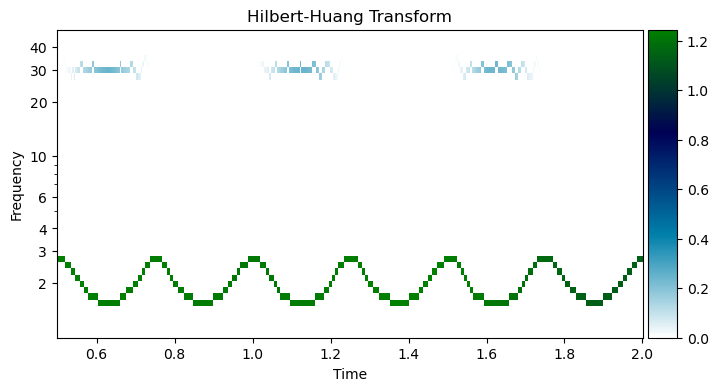

In [11]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
f, hht = emd.spectra.hilberthuang(IF, IA, (1, 50, 49, 'log'), sum_time=False)

plt.figure(figsize=(8,4))
ax = plt.subplot(111)
emd.plotting.plot_hilberthuang(hht, time_vect, f,
                               log_y=True, cmap='ocean_r',
                               ax=ax, time_lims=(0.5, 2))

## Oscillations in Noise



Lets take a look at how itEMD performs on a couple of noisy signals. Here we
look at a dynamic 15Hz oscillation embedded in white noise. The itEMD is able
to isolate the oscillation into a single component.



<AxesSubplot:xlabel='Time (samples)'>

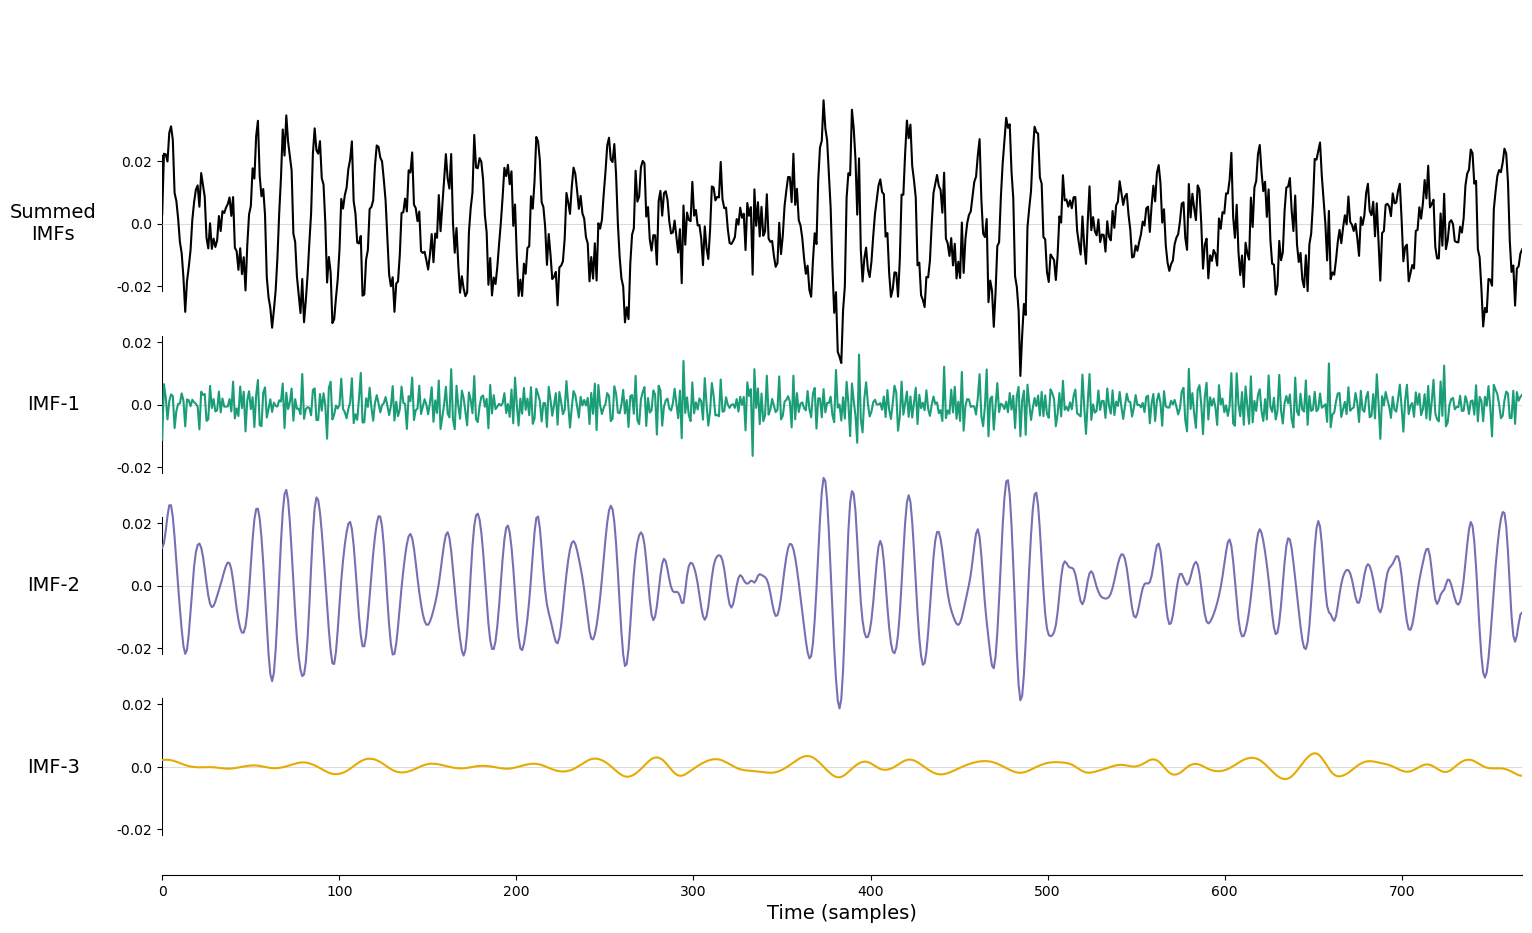

In [12]:
# Define and simulate a simple signal
peak_freq = 15
sample_rate = 256
seconds = 3
noise_std = .4
x = emd.simulate.ar_oscillator(peak_freq, sample_rate, seconds,
                          noise_std=noise_std, random_seed=42, r=.96)[:, 0]
x = x*1e-4

imf = emd.sift.iterated_mask_sift(x, sample_rate=sample_rate, max_imfs=3)
emd.plotting.plot_imfs(imf)

And, finally, we look at the how iterated mask sifting handles the signal
from the Holospectrum tutorial. This case contains several oscillations with
complex amplitude modulations. These are nicely separated into two IMFs.



In [13]:
seconds = 4
sample_rate = 200
t = np.linspace(0, seconds, seconds*sample_rate)

# First we create a slow 4.25Hz oscillation with a 0.5Hz amplitude modulation
slow = np.sin(2*np.pi*5*t) * (.5+(np.cos(2*np.pi*.5*t)/2))

# Second, we create a faster 37Hz oscillation that is amplitude modulated by the first.
fast = .5*np.sin(2*np.pi*37*t) * (slow+(.5+(np.cos(2*np.pi*.5*t)/2)))

# We create our signal by summing the oscillation and adding some noise
x = slow+fast + np.random.randn(*t.shape)*.05

imf = emd.sift.iterated_mask_sift(x, sample_rate=sample_rate, max_imfs=5)
emd.plotting.plot_imfs(imf)

/storage2/arash/miniconda3/envs/LFP-Grid/lib/python3.10/site-packages/numpy/lib/function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low



Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


LinAlgError: SVD did not converge in Linear Least Squares

Depending on the nature of the data, some itEMD options may need to be
modified. For instance, the max_iter argument can be increased if itEMD
reaches the maximum number of iterations, or iter_th can be modified to make
the convergence criterion more stringent.

To isolate very transient and infrequent oscillations, it may be a good idea
to try different instantaneous amplitude weighting for the iteration process
(keyword argument w_method). Finally, if the data is non-stationary such that
different masks might be appropriate for different segments of the signal
then the time-series should first be segmented and itEMD applied to
quasi-stationary segments as it assumes one equilibrium can be found.

For more information, see the documentation for emd and Fabus et al (2021)
Journal of Neurophysiology..



## Further Reading & References



Marco S. Fabus, Andrew J. Quinn, Catherine E. Warnaby, and Mark W. Woolrich (2021).
Automatic decomposition of electroptysiological data into distinct nonsinusoidal oscillatory modes.
Journal of Neurophysiology 2021 126:5, 1670-1684.
https://doi.org/10.1152/jn.00315.2021

